In [257]:
import os 
import pandas as pd
import subprocess as sp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick
import pyarrow.parquet as pq

In [259]:
# standardized paths
base_path = sp.getoutput('git rev-parse --show-toplevel')
eda_figures_path = os.path.join(base_path, 'eda' , 'eda_figures')
data_path = os.path.join(base_path, 'data')
csv_list = os.listdir(data_path)


In [260]:
df_list = []

for filename in csv_list:

    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(data_path,filename), index_col=None, header=0)

    elif filename.endswith('.parquet'):
        df = pq.read_table(os.path.join(data_path,filename), index_col=None, header=0)
        df = df.to_pandas()
        
    df_list.append(df)

df_base = pd.concat(df_list, axis=0, ignore_index=True)

/var/folders/qv/vr4x2m4s0m53q79m582_pwt00000gn/T/ipykernel_76269/3708085334.py:5: DtypeWarning: Columns (60,62,64,66,68) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_path,filename), index_col=None, header=0)
/var/folders/qv/vr4x2m4s0m53q79m582_pwt00000gn/T/ipykernel_76269/3708085334.py:5: DtypeWarning: Columns (58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_path,filename), index_col=None, header=0)
/var/folders/qv/vr4x2m4s0m53q79m582_pwt00000gn/T/ipykernel_76269/3708085334.py:5: DtypeWarning: Columns (58,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_path,filename), index_col=None, header=0)
/var/folders/qv/vr4x2m4s0m53q79m582_pwt00000gn/T/ipykernel_76269/3708085334.py:5: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.rea

In [108]:
df_base['year_grouping'] = np.where(df_base['year'] < 1962, '1956-1961',
                           np.where((df_base['year'] < 2000) & (df_base['year'] > 1962), '1993-1999',
                           np.where(df_base['year'] > 2012, '2013-2019', np.nan)))

## Count by Case Year

In [249]:
df = df_base.copy()

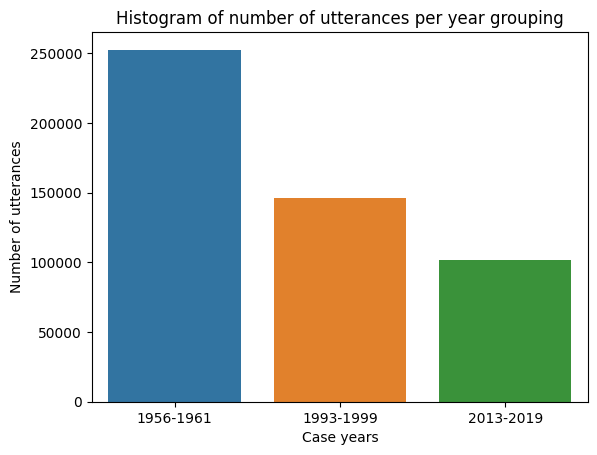

In [251]:

(pd.DataFrame(df['year_grouping']
    .value_counts()
    .reset_index()))

sns.barplot(data=((pd.DataFrame(df['year_grouping']
                     .value_counts()
                     .reset_index()))),
            x='year_grouping',
            y='count')


plt.xlabel('Case years')
plt.ylabel('Number of utterances')
plt.title('Number of utterances per year grouping');

plt.savefig(os.path.join(eda_figures_path, 'num_utter_per_year_group.png'),
            bbox_inches='tight')

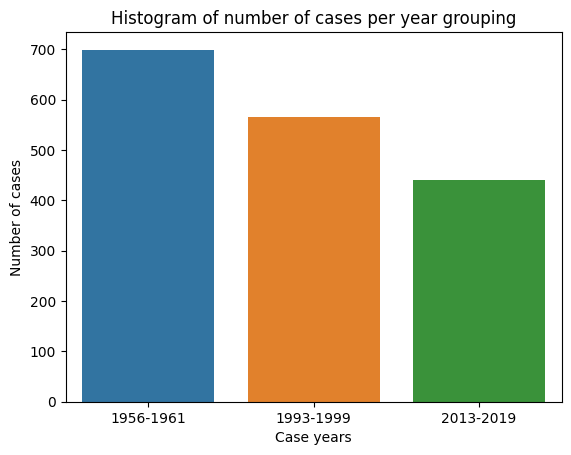

In [252]:
sns.barplot(data=(df[['year_grouping', 'case_id']]
                    .drop_duplicates()
                    .groupby('year_grouping')
                    .count()
                    .reset_index()),
            x='year_grouping',
            y='case_id')


plt.xlabel('Case years')
plt.ylabel('Number of cases')
plt.title('Number of cases per year grouping');

plt.savefig(os.path.join(eda_figures_path, 'num_cases_per_year_group.png'),
            bbox_inches='tight')


## Histogram of utterance word count

In [136]:
df = df_base.copy()

In [137]:
# Define a function to count words in a string
def count_words(s):
    return len(s.split())

In [138]:
# Apply the function to the text column and store the result in a new column
df['word_count'] = df['text'].apply(count_words)

In [141]:
bins = [0, 26, 51, 101, 201, 501, 1001, df['word_count'].max()]
labs = []
for i, lab in enumerate(bins[0:-1]):
    if i == 0:
        continue
    labs.append(f'{bins[i-1]}-{lab-1}')
labs.append(f'>{bins[-2] - 1}')
word_count_df = pd.DataFrame({'word_count': df['word_count'],
                              'word_count_group': pd.cut(df['word_count'], bins=bins, labels=labs),
                              'year_grouping': df['year_grouping']})

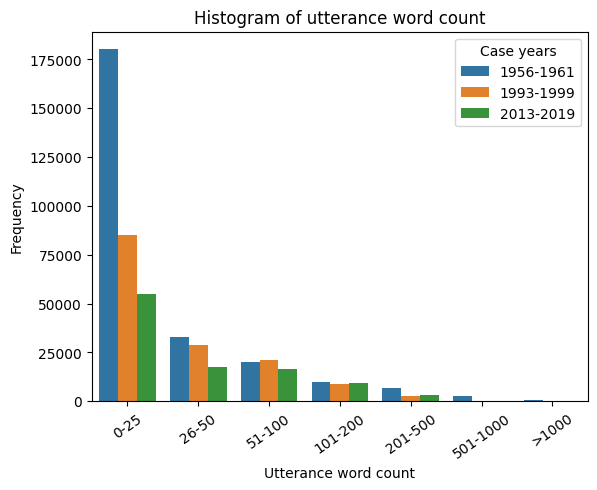

In [146]:
ax = sns.countplot(data=word_count_df, x='word_count_group', hue='year_grouping')
ax.tick_params(axis='x', labelrotation=35)
plt.xlabel('Utterance word count')
plt.ylabel('Frequency')
plt.legend(title='Case years')
plt.title('Histogram of utterance word count');

plt.savefig(os.path.join(eda_figures_path, 'hist_utter_word_count_per_year_group.png'),
            bbox_inches='tight')

## Number of utterances by case

In [158]:
df = df_base.copy()
df_utter_by_case = df.groupby(['case_id'], as_index=False).agg({'text': 'count', 'year_grouping': 'first'})

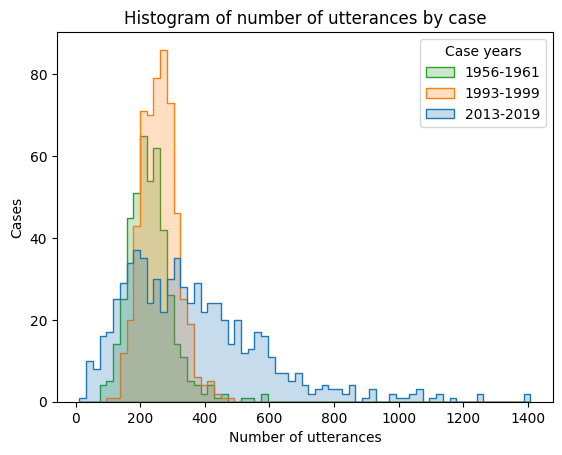

In [167]:
sns.histplot(data=df_utter_by_case, x='text', hue='year_grouping', element='step')
plt.xlabel('Number of utterances')
plt.ylabel('Cases')
plt.legend(title='Case years', labels=df_utter_by_case.year_grouping.unique())
plt.title('Histogram of number of utterances by case');

plt.savefig(os.path.join(eda_figures_path, 'hist_num_utter_per_year_group.png'),
            bbox_inches='tight')

## Median length of utterance by case

In [168]:
df = df_base.copy()

In [169]:
# Define a function to count words in a string
def count_words(s):
    return len(s.split())

In [170]:
df['word_count'] = df['text'].apply(count_words)

In [171]:
df_utter_length_by_case = df.groupby(['case_id'], as_index=False).agg({'word_count': 'median', 'year_grouping': 'first'})

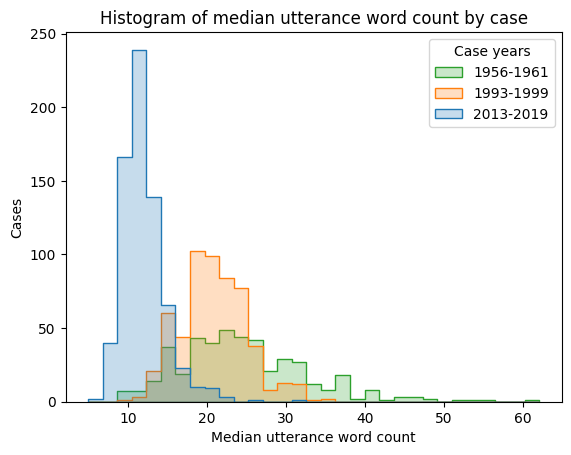

In [175]:
sns.histplot(data=df_utter_length_by_case, x='word_count', hue='year_grouping', element='step')
plt.xlabel('Median utterance word count')
plt.ylabel('Cases')
plt.legend(title='Case years', labels=df_utter_by_case.year_grouping.unique())
plt.title('Histogram of median utterance word count by case');

plt.savefig(os.path.join(eda_figures_path, 'hist_median_utter_word_count_per_year_group.png'),
            bbox_inches='tight')

## Win side

In [219]:
df = df_base.copy()

In [220]:
df_avg_case_outcome = (df.groupby(['case_id'], as_index=False)
                         .agg({'win_side': 'mean', 'year_grouping': 'first'})
                         .groupby(['year_grouping'], as_index=False)
                         .agg({'win_side': 'mean'}))



In [222]:
avg_case_outcome_all_data = (df.groupby(['case_id'], as_index=False)
                                  .agg({'win_side': 'mean'})
                                  ['win_side'].mean())

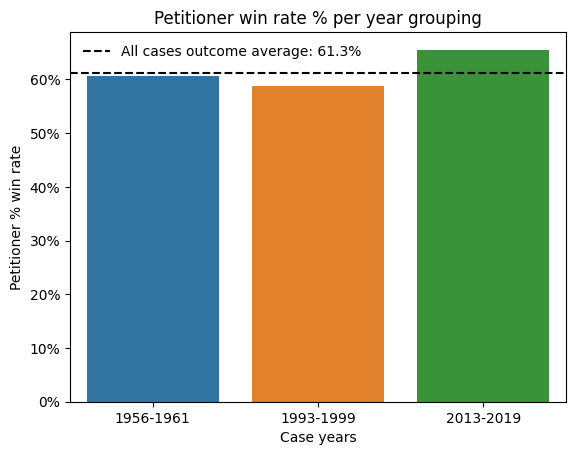

In [238]:
ax = sns.barplot(data=df_avg_case_outcome,
            x='year_grouping',
            y='win_side')


plt.xlabel('Case years')
plt.ylabel('Petitioner % win rate')
plt.title('Petitioner win rate % per year grouping')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
plt.axhline(y=avg_case_outcome_all_data,
            color='black',
            linestyle='dashed',
            label=f'All cases outcome average: {round(avg_case_outcome_all_data * 100, 1)}%')
plt.legend(frameon=False);

plt.savefig(os.path.join(eda_figures_path, 'avg_petitioner_winrate_per_year_group.png'),
            bbox_inches='tight')
